# IHS
## NLP Pipeline

In [72]:
# Make sure we are working vs. the correct MLRun & Storey version
!python -m pip uninstall mlrun -y
!python -m pip install git+https://github.com/yaronha/mlrun.git@feature-store
!python -m pip install git+https://github.com/mlrun/storey.git@development

Found existing installation: mlrun unstable
Uninstalling mlrun-unstable:
  Successfully uninstalled mlrun-unstable
  Cloning https://github.com/yaronha/mlrun.git (to revision feature-store) to /tmp/pip-req-build-bvhn2zdr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mlrun: filename=mlrun-unstable-py3-none-any.whl size=317837 sha256=e07fe73280f85342c934fa12c2257bcd3a82baa4d6eebad0c2e55e6df1c89c8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hevirs6z/wheels/0c/7f/4e/5179e5b7309dc86625e13cc4baccaa395fe6ff73c0c96f2e74
Successfully built mlrun


## Create the NLP Processing flow

In [3]:
import mlrun
from nlp import *
from entities_flows import *

### Function Definition

Use `code_to_function` to initialize the function with the base code from `nlp.py` and add spec info as `kind` and `image`.  

Append the second designated function via `add_child_function` to the workflow, importing the defined classes and functions and enabling it as a `function=<function_name>` step parameter.

In [43]:
fn = mlrun.code_to_function('nlp-pipeline', filename='./nlp.py', kind='serving', image='mlrun/mlrun')

In [ ]:
fn2 = fn.add_child_function('enrich', './entity_extraction.ipynb', 'mlrun/mlrun')

In [45]:
# Add the relevant build commands to make sure our final image has all the requirements
build_commands = ['pip install git+https://github.com/mlrun/storey.git@development',
                  'pip uninstall mlrun -y',
                  'pip install git+https://github.com/yaronha/mlrun.git@feature-store']

fn.spec.build.commands = build_commands

### Graph Definition

In [46]:
# Define working streams
stream_path = "users/admin/test_stream_1"
resp_stream_path = "users/admin/resp-stream"
error_stream = "users/admin/flow_test/errstream"

# Define computation graph
graph = fn.set_topology("flow", engine="async", exist_ok=True)
graph.to('URLDownloader')\
     .to('ToParagraphs')\
     .to(name='to_json', handler='json.dumps')\
     .to('>', 'to_v3io', path=stream_path)\
     .to("ApplyNLP", function='enrich')\
     .to('ExtractEntities', function='enrich')\
     .to('EnrichEntities', function='enrich')\
     .to('storey.FlatMap', 'flatten', _fn='(event)', function='enrich')\
     .to('>', 'to_result', path=resp_stream_path)

# Add error stream recording
fn.spec.error_stream = error_stream

# Enable Verbose for debugging
fn.verbose = True

### Plot function graph

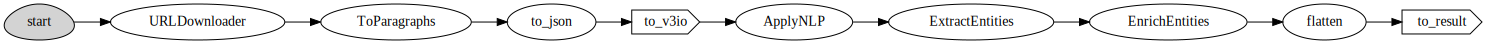

In [47]:
graph.plot(rankdir='LR')

## Create test mock server

In [50]:
server = fn.to_mock_server()
server.verbose = True
server.set_error_stream("users/admin/flow_test/errstream")

### Test local server

In [ ]:
msg = b's3://igz-downloads/1.json'
server.test(path='/', body=msg)
server.wait_for_completion()

## Deploy functions to the cluster

In [20]:
fn.apply(mlrun.v3io_cred())
fn.deploy()

> 2020-12-14 13:18:00,879 [info] deploy child function enrich ...
> 2020-12-14 13:18:00,898 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': 'unstable', 'client_version': 'unstable'}
> 2020-12-14 13:18:00,898 [info] Starting remote function deploy
2020-12-14 13:18:00  (info) Deploying function
{'level': 'info', 'message': 'Deploying function', 'name': 'default-nlp-pipeline-enrich', 'time': 1607951880981.729}
2020-12-14 13:18:00  (info) Building
{'level': 'info', 'message': 'Building', 'name': 'default-nlp-pipeline-enrich', 'time': 1607951880981.7642, 'versionInfo': 'Label: 1.4.19, Git commit: 141d873723fc258fc73901f7c61dc1bef54d04bc, OS: linux, Arch: amd64, Go version: go1.14.3'}
2020-12-14 13:18:01  (info) Staging files and preparing base images
{'level': 'info', 'message': 'Staging files and preparing base images', 'name': 'deployer', 'time': 1607951881017.8608}
2020-12-14 13:18:01  (info) Building processor image
{'imageName': 'default-defa

'http://default-tenant.app.yh210.iguazio-cd2.com:32040'

In [52]:
fn.
print(fn.spec.to_yaml())

command: ''
args: []
image: mlrun/mlrun
entry_points:
  do:
    name: do
    doc: ''
    parameters:
    - name: self
      default: ''
    - name: docs
      type: Union[List, Event]
      default: ''
    outputs:
    - default: ''
    lineno: 57
  to_paragraphs:
    name: to_paragraphs
    doc: ''
    parameters:
    - name: docs
      type: Union[List, Event]
      default: ''
    outputs:
    - default: ''
    lineno: 73
  init_context:
    name: init_context
    doc: ''
    parameters:
    - name: context
      default: ''
    outputs:
    - default: ''
    lineno: 87
  handler:
    name: handler
    doc: ''
    parameters:
    - name: context
      default: ''
    - name: event
      default: ''
    outputs:
    - default: ''
    lineno: 90
description: ''
min_replicas: 1
max_replicas: 4
volumes: []
volume_mounts: []
env: []
base_spec:
  apiVersion: nuclio.io/v1
  kind: Function
  metadata:
    name: nlp-pipeline
    labels: {}
    annotations:
      nuclio.io/generated_by: funct

## Test deployed functions

In [37]:
fn.invoke(path='/', body='s3://igz-downloads/1.json')

{'id': '9cb24f01-8b65-47f6-8e9e-0b1124c167cb'}